In [1]:
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

import scrape
import yelp
import constants

sys.path.append("../helpers/")
import helpers

%load_ext autoreload
%autoreload 2

In [2]:
import nord_vpn

from sys import platform

if platform != "darwin":
    pass
    vpn = nord_vpn.NordVPN()
    vpn.connect()
    vpn.disconnect()
    vpn.check_status()

In [3]:
url = scrape.get_michelin_guide_url("new york", "new york", stars="1")
print(url)

https://guide.michelin.com/us/en/new-york-state/new-york/restaurants/1-star-michelin


In [4]:
restaurant_html_list = scrape.get_michelin_guide_restaurant_html_list("new york", "new york", stars="3")
restaurant_html = restaurant_html_list[0]

In [5]:
scrape.MichelinRestaurant(restaurant_html_list[1])

['355', 'USD', '•', 'Contemporary', 'French']


Per Se | 3 Stars | 4.6 Stars (Google Reviews)| 355

In [6]:
# restaurant_html_list = scrape.get_michelin_guide_restaurant_html_list("new york", "new york", stars="1+")
# restaurant_list = scrape.get_convert_restaurant_html_list_to_restaurants(restaurant_html_list)
# restaurant_list = sorted(restaurant_list)

# Michelin Star Restaurants

In [7]:
# restaurant_data = pd.DataFrame([(restaurant.name, restaurant.cost, restaurant.distinction,
#                                  restaurant.google_rating, restaurant) for restaurant in restaurant_list],
#                                columns=["name", "cost", "michelin_stars", "google_rating", "restaurant"])

In [8]:
# restaurant_data = restaurant_data.sort_values(by=["cost", "google_rating"], ascending=[True, False]).reset_index()
# restaurant_data.head(50)

# Bib Gourmand

In [9]:
# bib_gourmand_restaurant_html_list = scrape.get_michelin_guide_restaurant_html_list("new york", "new york", stars="0")
# bib_gourmand_restaurant_list = scrape.get_convert_restaurant_html_list_to_restaurants(bib_gourmand_restaurant_html_list)
# bib_gourmand_restaurant_list = sorted(bib_gourmand_restaurant_list)

In [10]:
# bib_gourmand_restaurant_data = pd.DataFrame([(restaurant.name, restaurant.cost, restaurant.distinction,
#                                  restaurant.google_rating, restaurant) for restaurant in bib_gourmand_restaurant_list],
#                                columns=["name", "cost", "michelin_stars", "google_rating", "restaurant"])

# bib_gourmand_restaurant_data = bib_gourmand_restaura`nt_data.sort_values(by=["cost", "google_rating"],
#                                                                         ascending=[True, False]).reset_index()
# bib_gourmand_restaurant_data.query("google_rating == 4.3").head(50)

# Yelp Data Pulling

In [11]:
overwrite = False

In [12]:
data = helpers.cached_function(f"data/yelp_data.pkl", yelp.get_all_restaurants,
                               "restaurant", price="1,2,3,4", sort_by="rating", location="NYC", top=1000,
                               per_price=True, overwrite=False)

In [13]:
restaurant_data = yelp.yelp_data_to_restaurant_df(data)
restaurant_data = restaurant_data.query("rating > 3.5 and review_count > 40")
restaurant_data.sort_values(["rating", "review_count"], ascending=False, inplace=True)
restaurant_data.reset_index(inplace=True)

restaurant_data = restaurant_data

In [14]:
restaurant_data.head()

,index,name,review_count,rating,id,alias,price,categories,address,city
0,1900,Haidilao Hot Pot Flushing,1784,5.0,jWuUibgnTGsJibOrr6UUSw,haidilao-hot-pot-flushing-flushing,$$$,"Hot Pot, Chinese","138-23 39th Ave, Flushing, NY 11354",Flushing
1,956,The Alcove,1027,5.0,MNNpsRXe7Wt5m3Jla9Wk0w,the-alcove-sunnyside,$$,"Gastropubs, Tapas Bars, Breakfast & Brunch","41-11 49th St, Sunnyside, NY 11104",Sunnyside
2,1901,Otis,446,5.0,RfxOtJ4SQmEeVX_XjFLWUQ,otis-brooklyn-2,$$$,"American (New), Cocktail Bars","18 Harrison Pl, Brooklyn, NY 11206",Brooklyn
3,958,Scott's Pizza Tours,355,5.0,VP3-iMnKK_TaHDuy6mxTzA,scotts-pizza-tours-new-york,$$,"Pizza, Food Tours, Walking Tours","New York, NY 10001",New York
4,14,Joey Bats Café,349,5.0,uYMimeHJ5XBGkyTrg8GXhw,joey-bats-café-new-york,$,"Desserts, Portuguese, Cafes","129 Allen St, New York, NY 10002",New York


In [15]:
restaurant_data = helpers.cached_function("data/yelp_data_with_google_reviews.pkl",
                                          yelp.add_google_place_info, restaurant_data, overwrite=False)
restaurant_data.query("google_rating > 4 and google_ratings_total > 40", inplace=True)

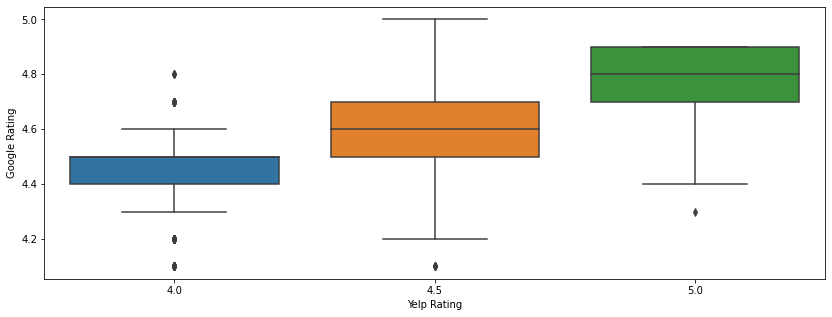

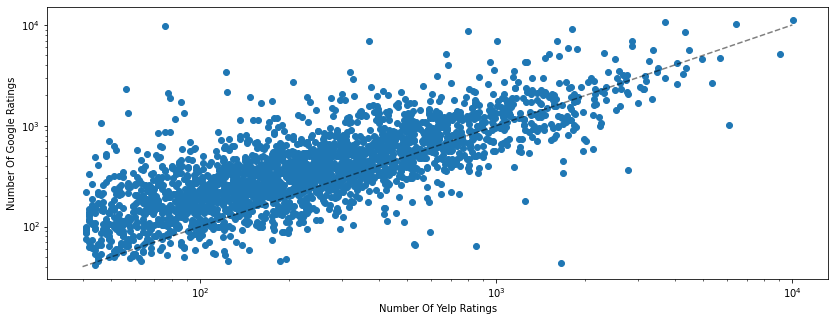

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.boxplot(data=restaurant_data, x="rating", y="google_rating", ax=ax)
helpers.add_plt_labels(ax, x="Yelp Rating", y="Google Rating")

fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter(data=restaurant_data, x="review_count", y="google_ratings_total")
ax.plot([40, 10000], [40, 10000], linestyle="--", color="k", alpha=.5)
helpers.add_plt_labels(ax, x="Number of Yelp Ratings", y="Number of Google Ratings")
ax.set_xscale("log")
ax.set_yscale("log")

In [17]:
restaurant_data

,index,name,review_count,rating,id,alias,price,categories,address,city,google_rating,google_ratings_total,google_price,status
0,1900,Haidilao Hot Pot Flushing,1784,5.0,jWuUibgnTGsJibOrr6UUSw,haidilao-hot-pot-flushing-flushing,$$$,"Hot Pot, Chinese","138-23 39th Ave, Flushing, NY 11354",Flushing,4.8,2445.0,2.0,OPERATIONAL
1,956,The Alcove,1027,5.0,MNNpsRXe7Wt5m3Jla9Wk0w,the-alcove-sunnyside,$$,"Gastropubs, Tapas Bars, Breakfast & Brunch","41-11 49th St, Sunnyside, NY 11104",Sunnyside,4.8,978.0,2.0,OPERATIONAL
2,1901,Otis,446,5.0,RfxOtJ4SQmEeVX_XjFLWUQ,otis-brooklyn-2,$$$,"American (New), Cocktail Bars","18 Harrison Pl, Brooklyn, NY 11206",Brooklyn,4.8,669.0,2.0,OPERATIONAL
4,14,Joey Bats Café,349,5.0,uYMimeHJ5XBGkyTrg8GXhw,joey-bats-café-new-york,$,"Desserts, Portuguese, Cafes","129 Allen St, New York, NY 10002",New York,4.8,413.0,1.0,OPERATIONAL
5,957,Korai Kitchen,308,5.0,3rZwXDjkyDLAHNSdPUI5WA,korai-kitchen-jersey-city,$$,Bangladeshi,"576 Summit Ave, Jersey City, NJ 07306",Jersey City,4.8,525.0,2.0,OPERATIONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2695,University Club,45,4.0,JbXpcBhrSItNZ2DBPS9u9w,university-club-new-york,$$$,"Social Clubs, American (Traditional)","1 W 54th St, New York, NY 10019",New York,4.3,67.0,NaN,OPERATIONAL
2638,2719,Salvi Restaurant,44,4.0,q1F09j4JFRZQJ2e11m7lGg,salvi-restaurant-brooklyn,$$$,Italian,"4220 Quentin Rd, Brooklyn, NY 11234",Brooklyn,4.5,151.0,2.0,OPERATIONAL
2639,2761,The Kosher Marketplace,44,4.0,E5aMm_pUrb8QfaFxM6Dv9g,the-kosher-marketplace-new-york,$$$,"Specialty Food, Grocery, Kosher","2442 Broadway, New York, NY 10024",New York,4.5,96.0,NaN,OPERATIONAL
2640,3031,Odo,44,4.0,56PeolgNURAG4x6q7nanmw,odo-new-york,$$$$,Japanese,"17 W 20th St, New York, NY 10011",New York,4.6,95.0,NaN,OPERATIONAL


In [76]:
categories = sorted(set([i.strip() for item in data["categories"] for i in item.split(",")]))

category_matrix = np.zeros((len(categories), len(categories)))
pbar = tqdm(total=np.prod(category_matrix.shape), desc="Building Category Association Matrix", unit=" Category")
for i, category_i in enumerate(categories):
#     is_category_i = data["categories"].str.contains(category_i)
    is_category_i = data["categories"].apply(lambda s: category_i in s)
    for j, category_j in enumerate(categories):
#         category_matrix[i, j] = np.count_nonzero(is_category_i & data["categories"].str.contains(category_j))
        category_matrix[i, j] = np.count_nonzero(is_category_i & data["categories"].apply(lambda s: category_j in s))
        pbar.update(1)

Building Category Association Matrix:   0%|          | 0/35721 [00:00<?, ? Category/s]

In [198]:
category_data = pd.DataFrame(category_matrix / np.diag(category_matrix), columns=categories, index=categories)
# category_data = pd.DataFrame(category_matrix, columns=categories, index=categories)

In [199]:
def category_vec(string):
    return np.array([category in string for category in categories]) * 1

X = np.vstack(data["categories"].apply(category_vec).values)

In [200]:
X = X / X.sum(axis=1).reshape(-1, 1)

In [201]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

print(pca.explained_variance_ratio_)

from sklearn.cluster import DBSCAN

[0.09295003 0.07075665]


In [202]:
clustering = DBSCAN(eps=.4, min_samples=10).fit(X)
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

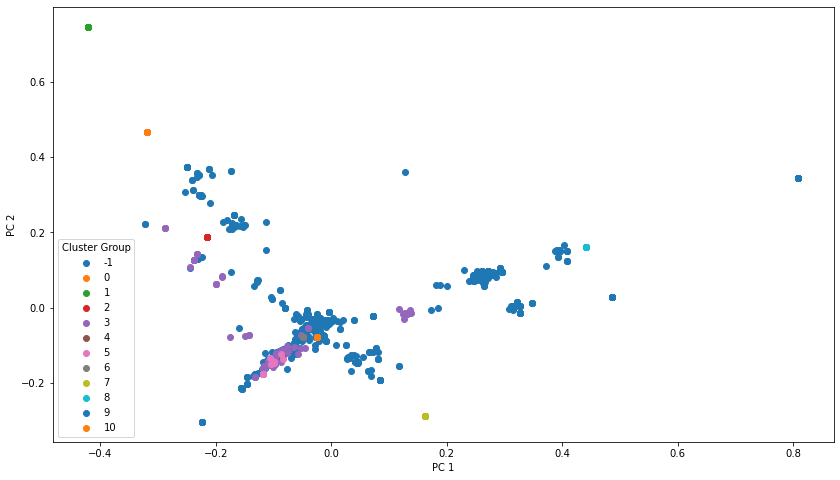

In [203]:
x = pca.transform(X)
fig, ax = plt.subplots(figsize=(14, 8))
for label in np.unique(clustering.labels_):
    index = clustering.labels_ == label
    ax.scatter(x[:, 0][index], x[:, 1][index], label=label)
ax.legend(title="Cluster Group")
helpers.add_plt_labels(ax, x="PC 1", y="PC 2")

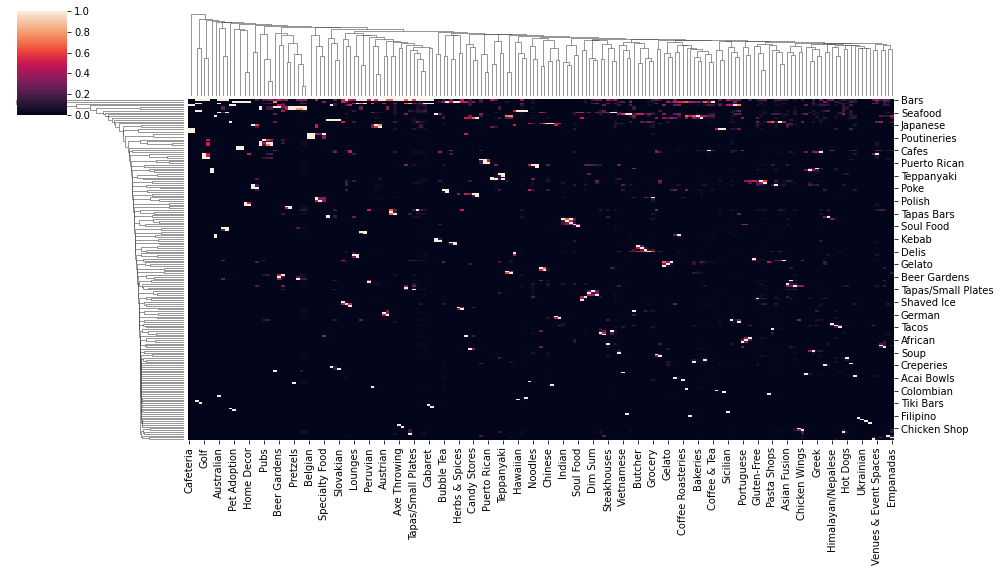

In [204]:
sns.clustermap(category_data, figsize=(14, 8))

In [24]:
data = restaurant_data.query("google_rating > 4.5 and rating >= 4.5").sort_values("google_rating")
data.query("price == '$'")

,index,name,review_count,rating,id,alias,price,categories,address,city,google_rating,google_ratings_total,google_price,status
1138,198,Urban Leaf Cafe,144,4.5,fPTn5vF2ebsapsfJHpw82A,urban-leaf-cafe-nutley-2,$,"Desserts, Coffee & Tea, Bubble Tea","182 D Kingsland St, Nutley, NJ 07110",Nutley,4.6,216.0,NaN,OPERATIONAL
628,273,Piz-zetta,317,4.5,i_rg-OLXQbpRUN7O3MeCeA,piz-zetta-brooklyn-2,$,"Italian, Pizza","90 Livingston St, Brooklyn, NY 11201",Brooklyn,4.6,297.0,2.0,OPERATIONAL
612,168,Dulce De Leche Bakery,328,4.5,eaevhIPvdYa7A6jTrrCewQ,dulce-de-leche-bakery-west-new-york,$,"Bakeries, Cafes, Empanadas","6510 Bergenline Ave, West New York, NJ 07093",West New York,4.6,2930.0,1.0,OPERATIONAL
606,222,Wowfulls,331,4.5,htXRzg3a3jMQt3mg_zM-yQ,wowfulls-brooklyn-9,$,"Desserts, Waffles, Ice Cream & Frozen Yogurt","90 Kent Ave, Brooklyn, NY 11249",Brooklyn,4.6,353.0,1.0,OPERATIONAL
594,300,Margherita Pizza,340,4.5,Gh7XAH2xT3lnpOERhzSNxA,margherita-pizza-jamaica,$,Pizza,"163-04 Jamaica Ave, Jamaica, NY 11432",Jamaica,4.6,1278.0,1.0,OPERATIONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,28,Sonbobs,57,5.0,lm6AchFt32BqTf3OoQBBPw,sonbobs-astoria,$,"Coffee & Tea, Desserts, Sandwiches","34-15 28th Ave, Astoria, NY 11103",Astoria,4.9,76.0,1.0,OPERATIONAL
1771,410,Juju Cafe and Deli,41,4.5,gxrxuP4_Mc_WbISGotgiLw,juju-cafe-and-deli-brooklyn,$,"Cafes, Delis, Japanese","143 Smith St, Brooklyn, NY 11201",Brooklyn,4.9,96.0,NaN,OPERATIONAL
121,45,Eugene J. Candy Co.,49,5.0,CAVAhULoGltO1GpmBqwY3Q,eugene-j-candy-co-brooklyn-4,$,"Candy Stores, Desserts, Gift Shops","16 Wilson Ave, Brooklyn, NY 11237",Brooklyn,4.9,107.0,NaN,OPERATIONAL
1448,77,Burmese Bites,88,4.5,YtU1rb_oDHTbYzl-NFglPQ,burmese-bites-elmhurst-2,$,Burmese,"90-15 Queens Blvd, Elmhurst, NY 11373",Elmhurst,5.0,50.0,NaN,OPERATIONAL


In [ ]:
t = YelpRestaurant(data["businesses"][0])
vars(t)

In [ ]:
class YelpRestaurant:
    def __init__(self, yelp_data: dict):
        for key, value in yelp_data.items():
            self.__dict__[key] = value
        
        self.google_rating = get_google_rating(f"{self.alias}")

In [ ]:
data["businesses"][3]